# Setup Environment

In [ ]:
!pip install rasterio geopandas rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 47.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Vegetation Indices Extraction

**Catatan:**

File .tif pada notebook merupakan hasil pengambilan citra di GEE yang telah digabung dengan shapefile per daerah.

Berikut link snapshot GEE code editor: https://code.earthengine.google.com/e2f7355f785bc9b5a092acba04bf8b33

In [ ]:
file_path = [
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_BANGKALAN.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_bangkalan/AGRILADANG_AR_25K.shp', 'nama': 'Bangkalan'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_BATU.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_batu/AGRILADANG_AR_25K.shp', 'nama': 'Batu'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_BLITAR.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_blitar/AGRILADANG_AR_25K.shp', 'nama': 'Blitar'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_BLITAR_KOTA.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_blitar_kota/AGRILADANG_AR_25K.shp', 'nama': 'Blitar_Kota'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_BOJONEGORO.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_bojonegoro/AGRILADANG_AR_25K.shp', 'nama': 'Bojonegoro'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_BONDOWOSO.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_bondowoso/AGRILADANG_AR_25K.shp', 'nama': 'Bondowoso'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_JEMBER.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_jember/AGRILADANG_AR_25K.shp', 'nama': 'Jember'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_JOMBANG.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_jombang/AGRILADANG_AR_25K.shp', 'nama': 'Jombang'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_KEDIRI.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_kediri/AGRILADANG_AR_25K.shp', 'nama': 'Kediri'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_KEDIRI_KOTA.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_kediri_kota/AGRILADANG_AR_25K.shp', 'nama': 'Kediri_Kota'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_LAMONGAN.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_lamongan/AGRILADANG_AR_25K.shp', 'nama': 'Lamongan'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_LUMAJANG.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_lumajang/AGRILADANG_AR_25K.shp', 'nama': 'Lumajang'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_MADIUN.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_madiun/AGRILADANG_AR_25K.shp', 'nama': 'Madiun'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_MADIUN_KOTA.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_madiun_kota/AGRILADANG_AR_25K.shp', 'nama': 'Madiun_Kota'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_MAGETAN.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_magetan/AGRILADANG_AR_25K.shp', 'nama': 'Magetan'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_MALANG.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_malang/AGRILADANG_AR_25K.shp', 'nama': 'Malang'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_MALANG_KOTA.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_malang_kota/AGRILADANG_AR_25K.shp', 'nama': 'Malang_Kota'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_MOJOKERTO.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_mojokerto/AGRILADANG_AR_25K.shp', 'nama': 'Mojokerto'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_MOJOKERTO_KOTA.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_mojokerto_kota/AGRILADANG_AR_25K.shp', 'nama': 'Mojokerto_Kota'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_NGANJUK.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_nganjuk/AGRILADANG_AR_25K.shp', 'nama': 'Nganjuk'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_NGAWI.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_ngawi/AGRILADANG_AR_25K.shp', 'nama': 'Ngawi'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_PACITAN.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_pacitan/AGRILADANG_AR_25K.shp', 'nama': 'Pacitan'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_PAMEKASAN.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_pamekasan/AGRILADANG_AR_25K.shp', 'nama': 'Pamekasan'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_PASURUAN.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_pasuruan/AGRILADANG_AR_25K.shp', 'nama': 'Pasuruan'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_PASURUAN_KOTA.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_pasuruan_kota/AGRILADANG_AR_25K.shp', 'nama': 'Pasuruan_Kota'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_PONOROGO.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_ponorogo/AGRILADANG_AR_25K.shp', 'nama': 'Ponorogo'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_PROBOLINGGO.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_probolinggo/AGRILADANG_AR_25K.shp', 'nama': 'Probolinggo'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_PROBOLINGGO_KOTA.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_probolinggo_kota/AGRILADANG_AR_25K.shp', 'nama': 'Probolinggo_Kota'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_SAMPANG.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_sampang/AGRILADANG_AR_25K.shp', 'nama': 'Sampang'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_SIDOARJO.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_sidoarjo/AGRILADANG_AR_25K.shp', 'nama': 'Sidoarjo'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_SITUBONDO.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_situbondo/AGRILADANG_AR_25K.shp', 'nama': 'Situbondo'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_SUMENEP-0000016384-0000000000.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_sumenep/AGRILADANG_AR_25K.shp', 'nama': 'Sumenep'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_SURABAYA.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_surabaya/AGRILADANG_AR_25K.shp', 'nama': 'Surabaya'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_TUBAN.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_tuban/AGRILADANG_AR_25K.shp', 'nama': 'Tuban'},
    {'citra': '/content/drive/MyDrive/GEE_Exports_Jabar/sentinel2_TULUNGAGUNG.tif', 'lahan': '/content/drive/MyDrive/deteksi stres tanaman/shapefile_tulungagung/AGRILADANG_AR_25K.shp', 'nama': 'Tulungagung'},
]

In [ ]:
list_of_dfs = []

In [ ]:
SAMPEL_PER_WILAYAH = 2500

for paths in file_path:
    print(f"\n--- Memproses wilayah: {paths['nama']} ---")

    try:
        with rasterio.open(paths['citra']) as src_citra:
            gdf_lahan = gpd.read_file(paths['lahan'])

            if gdf_lahan.crs != src_citra.crs:
                gdf_lahan = gdf_lahan.to_crs(src_citra.crs)

            red = src_citra.read(1).astype('float32')
            red_edge = src_citra.read(2).astype('float32')
            nir = src_citra.read(3).astype('float32')
            swir = src_citra.read(4).astype('float32')

            np.seterr(divide='ignore', invalid='ignore')
            ndvi = np.nan_to_num((nir - red) / (nir + red))
            ndre = np.nan_to_num((nir - red_edge) / (nir + red_edge))
            ndmi = np.nan_to_num((nir - swir) / (nir + swir))

            peta_aturan = np.full(ndvi.shape, 1, dtype=np.int16)
            peta_aturan = np.where((ndvi > 0.75) & (ndre > 0.5) & (ndmi > 0.4), 2, peta_aturan)
            peta_aturan = np.where(ndvi < 0.2, 0, peta_aturan)

            fitur_lengkap = np.stack([ndvi, ndre, ndmi])

            mask_lahan, _, _ = rasterio.mask.raster_geometry_mask(src_citra, gdf_lahan.geometry, invert=True)

            row_coords, col_coords = np.where(mask_lahan)

            num_sampel_valid = min(SAMPEL_PER_WILAYAH, len(row_coords))
            random_indices = np.random.choice(len(row_coords), num_sampel_valid, replace=False)

            sampel_rows = row_coords[random_indices]
            sampel_cols = col_coords[random_indices]

            labels = peta_aturan[sampel_rows, sampel_cols]
            fitur_sampel = fitur_lengkap[:, sampel_rows, sampel_cols].T

            df_district = pd.DataFrame(fitur_sampel, columns=['NDVI', 'NDRE', 'NDMI'])
            df_district['stress_class'] = labels

            list_of_dfs.append(df_district)
            print(f"Selesai memproses {paths['nama']}, ditemukan {len(df_district)} sampel piksel.")

    except Exception as e:
        print(f"Gagal memproses {paths['nama']}: {e}")


--- Memproses wilayah: Bangkalan ---
Selesai memproses Bangkalan, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Batu ---


/usr/local/lib/python3.11/dist-packages/rasterio/mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


Selesai memproses Batu, ditemukan 0 sampel piksel.

--- Memproses wilayah: Blitar ---
Selesai memproses Blitar, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Blitar_Kota ---
Selesai memproses Blitar_Kota, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Bojonegoro ---
Selesai memproses Bojonegoro, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Bondowoso ---
Selesai memproses Bondowoso, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Jember ---
Selesai memproses Jember, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Jombang ---
Selesai memproses Jombang, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Kediri ---
Selesai memproses Kediri, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Kediri_Kota ---
Selesai memproses Kediri_Kota, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Lamongan ---


/usr/local/lib/python3.11/dist-packages/rasterio/mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


Selesai memproses Lamongan, ditemukan 0 sampel piksel.

--- Memproses wilayah: Lumajang ---
Selesai memproses Lumajang, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Madiun ---
Selesai memproses Madiun, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Madiun_Kota ---
Selesai memproses Madiun_Kota, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Magetan ---
Selesai memproses Magetan, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Malang ---
Selesai memproses Malang, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Malang_Kota ---
Selesai memproses Malang_Kota, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Mojokerto ---
Selesai memproses Mojokerto, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Mojokerto_Kota ---
Selesai memproses Mojokerto_Kota, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Nganjuk ---
Selesai memproses Nganjuk, ditemukan 2500 sampel piksel.

--- Memproses wilayah: Ngawi ---
Selesai memproses Ngawi, ditemukan 2500 sa

# Splitting Data

In [ ]:
df_train = pd.concat(list_of_dfs, ignore_index=True)
df_train.dropna(inplace=True)

print(f"Total sampel terkumpul dari semua wilayah: {len(df_train)}")

df_train.head()

Total sampel terkumpul dari semua wilayah: 80121


,NDVI,NDRE,NDMI,stress_class
0,0.500588,0.304907,0.015916,1
1,0.667622,0.437747,0.039471,1
2,0.520861,0.325125,-0.052212,1
3,0.698754,0.454898,0.154734,1
4,0.400778,0.230769,-0.055472,1


In [ ]:
len(df_train[df_train['stress_class'] == 0])

4043

# Modelling

In [ ]:
X = df_train.drop(columns=['stress_class'])
y = df_train['stress_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"\nAkurasi Model: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nLaporan Klasifikasi:\n", classification_report(y_test, y_pred))


Akurasi Model: 99.98%

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1253
           1       1.00      1.00      1.00     22641
           2       1.00      0.97      0.99       143

    accuracy                           1.00     24037
   macro avg       1.00      0.99      1.00     24037
weighted avg       1.00      1.00      1.00     24037



In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

print("\n================ HASIL CROSS-VALIDATION ================")
print(f"Skor Akurasi untuk setiap fold: {scores}")
print(f"Rata-rata Akurasi: {scores.mean():.4f}")
print(f"Standar Deviasi Akurasi: {scores.std():.4f}")


================ HASIL CROSS-VALIDATION ================
Skor Akurasi untuk setiap fold: [1.         1.         0.99981278 0.99993759 1.        ]
Rata-rata Akurasi: 1.0000
Standar Deviasi Akurasi: 0.0001


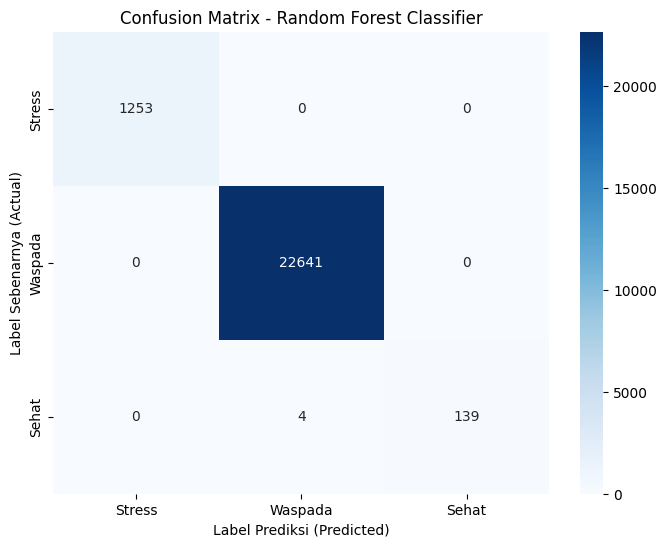

In [ ]:
class_names = ['Stress', 'Waspada', 'Sehat']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix - Random Forest Classifier')
plt.ylabel('Label Sebenarnya (Actual)')
plt.xlabel('Label Prediksi (Predicted)')

plt.show()


# Testing

**Catatan** : \
File .tif pada sel berikut merupakan hasil pengambilan citra di GEE secara sembarang.

Berikut link snapshot GEE code editor: https://code.earthengine.google.com/60b08819017076d4e2ec87e8077db056

In [ ]:
imagery_testing = '/content/drive/MyDrive/GEE_Exports_Inferensi/ladang_pilihan.tif'

In [ ]:
try:
    with rasterio.open(imagery_testing) as src:
        citra_array = src.read()
        profile = src.profile
except FileNotFoundError:
    print(f"Error: File citra tidak ditemukan di {imagery_testing}")

In [ ]:
b4_red = citra_array[2].astype('float32')
b5_red_edge = citra_array[3].astype('float32')
b8_nir = citra_array[6].astype('float32')
b11_swir = citra_array[8].astype('float32')

np.seterr(divide='ignore', invalid='ignore')

ndvi = np.nan_to_num((b8_nir - b4_red) / (b8_nir + b4_red))
ndre = np.nan_to_num((b8_nir - b5_red_edge) / (b8_nir + b5_red_edge))
ndmi = np.nan_to_num((b8_nir - b11_swir) / (b8_nir + b11_swir))

final_features = np.stack([
    citra_array[0], citra_array[1], citra_array[2], citra_array[3],
    citra_array[4], citra_array[5], citra_array[6], citra_array[7],
    citra_array[8], citra_array[9],
    ndvi, ndre, ndmi
])

In [ ]:
final_features.shape[0]

13

In [ ]:
num_features, height, width = final_features.shape

In [ ]:
features_reshaped = final_features.reshape(num_features, -1).T

In [ ]:
features_for_prediction = final_features[-3:, :, :]

num_features_pred, height_pred, width_pred = features_for_prediction.shape
features_reshaped = features_for_prediction.reshape(num_features_pred, -1).T

prediction = model.predict(features_reshaped)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


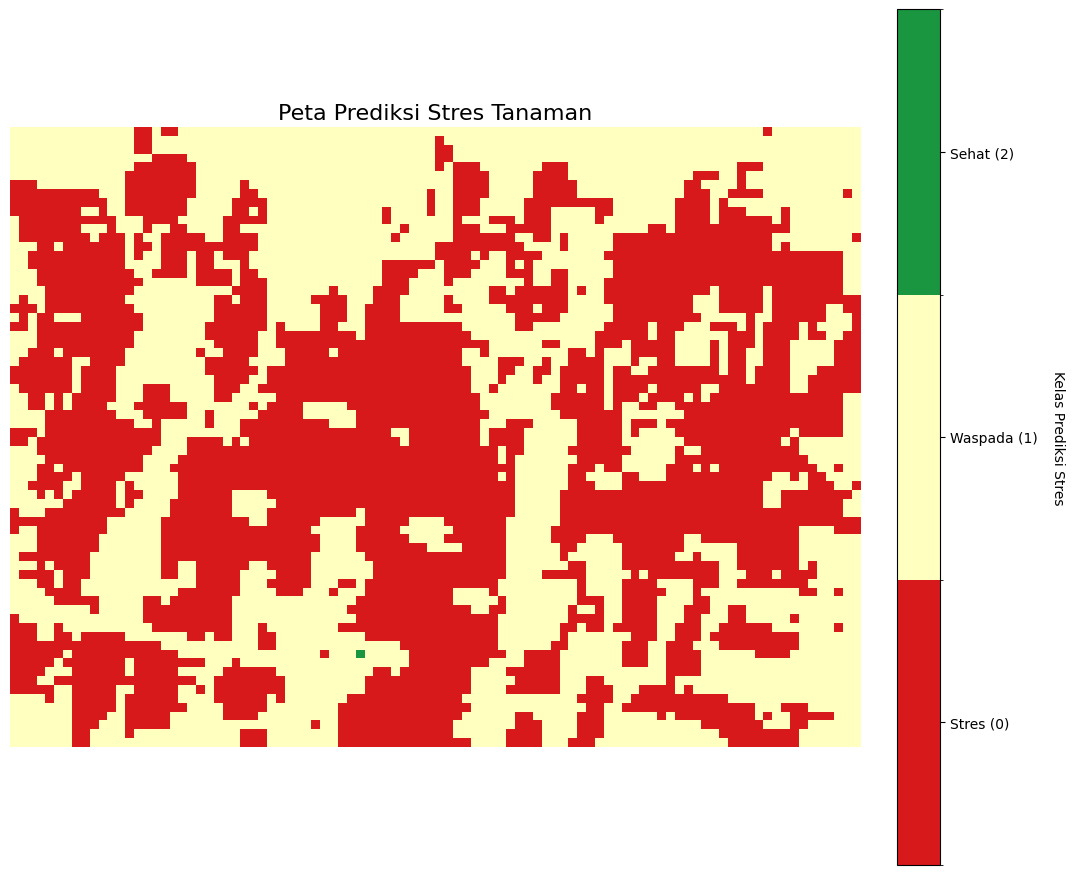

In [ ]:
map_prediction = prediction.reshape(height, width)

plt.figure(figsize=(12, 12))

cmap = plt.cm.colors.ListedColormap(['#d7191c', '#ffffbf', '#1a9641'])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

im = plt.imshow(map_prediction, cmap=cmap, norm=norm)

cbar = plt.colorbar(im, ticks=[0, 1, 2], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['Stres (0)', 'Waspada (1)', 'Sehat (2)'])
cbar.set_label('Kelas Prediksi Stres', rotation=270, labelpad=20)

plt.title('Peta Prediksi Stres Tanaman', fontsize=16)
plt.axis('off')
plt.show()

In [ ]:
def normalize(array):
    array_min, array_max = np.nanmin(array), np.nanmax(array)
    return ((array - array_min) / (array_max - array_min))

In [ ]:
nir_band = citra_array[6]
red_band = citra_array[2]
green_band = citra_array[1]

nir_norm = normalize(nir_band)
red_norm = normalize(red_band)
green_norm = normalize(green_band)

In [ ]:
false_color_composite = np.dstack((nir_norm, red_norm, green_norm))

Menampilkan Citra Asli (False-Color: NIR, Red, Green)


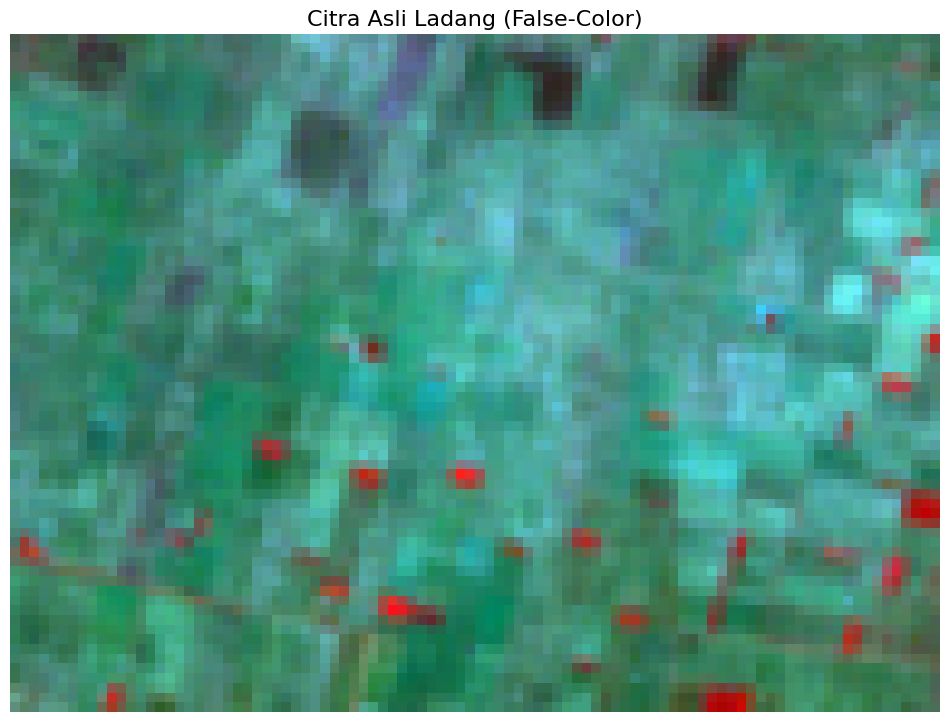

In [ ]:
print("Menampilkan Citra Asli (False-Color: NIR, Red, Green)")
plt.figure(figsize=(12, 12))
plt.imshow(false_color_composite)
plt.title('Citra Asli Ladang (False-Color)', fontsize=16)
plt.axis('off')
plt.show()

In [ ]:
total_pixels = map_prediction.size
stres_pixels = np.count_nonzero(map_prediction == 0)
waspada_pixels = np.count_nonzero(map_prediction == 1)
sehat_pixels = np.count_nonzero(map_prediction == 2)

persen_stres = (stres_pixels / total_pixels) * 100
persen_waspada = (waspada_pixels / total_pixels) * 100
persen_sehat = (sehat_pixels / total_pixels) * 100

kesimpulan = ""
if persen_stres > 25:
    kesimpulan = "Kondisi lahan secara umum KRITIS, sebagian besar area terindikasi stres berat dan perlu penanganan segera."
elif persen_stres > 10:
    kesimpulan = "Kondisi lahan secara umum PERLU PERHATIAN, terdeteksi beberapa area stres signifikan."
elif persen_waspada > 50:
    kesimpulan = "Kondisi lahan secara umum CUKUP BAIK, namun mayoritas berada dalam kondisi waspada dan berisiko stres."
elif persen_sehat > 75:
    kesimpulan = "Kondisi lahan secara umum SANGAT BAIK, mayoritas tanaman terdeteksi sehat."
else:
    kesimpulan = "Kondisi lahan secara umum BAIK dengan variasi tingkat kesehatan yang normal."

print(f"Persentase Area Stres (Merah):   {persen_stres:.2f}%")
print(f"Persentase Area Waspada (Kuning): {persen_waspada:.2f}%")
print(f"Persentase Area Sehat (Hijau):    {persen_sehat:.2f}%")

print(f"KESIMPULAN: {kesimpulan}")

Persentase Area Stres (Merah):   51.92%
Persentase Area Waspada (Kuning): 48.07%
Persentase Area Sehat (Hijau):    0.01%
KESIMPULAN: Kondisi lahan secara umum KRITIS, sebagian besar area terindikasi stres berat dan perlu penanganan segera.
